Goal of project:

1.Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

Note: for those first two steps don’t forget to normalize your features and randomize a selection for training and testing.

2.Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

Estimate a bounding box for vehicles detected.

In [232]:
# import useful libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import time
import pickle

from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label

from sklearn.metrics import recall_score,precision_score,f1_score

from PIL import Image
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import os

# utilities libraries
import random

%matplotlib inline

#1. Feature extraction - use histogram of oriented gradients on images
#2. Split into train and test set
#3. Then train linear svm classifier

In [110]:
# Extract Features - Helper functions

# 1. Function that returns HOG Features

# params are : num_blocks, cells_per_block, orientation_bins
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# 2. Function that iterates through images and calls a feature extractor
# feature_params can be a bunch of params
def get_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [3]:
# file utilities

def get_files(dir_path):
    files = []
    
    for file_name in os.listdir(dir_path):
        if file_name[-3:] =='png':
            files.append(dir_path+file_name)

    return files

def plot_single_images(cur_img_np,cur_img_features):

    # cur_img_np = numpy array of image
    
    fig = plt.figure(figsize=(10, 10))
    plt_n_rows = 1
    counter = 0

    # plot original image
    ## num rows, num cols, plotnumber
    plt.subplot(plt_n_rows,3,1+counter*3)
    plt.imshow(cur_img_np)

    # plot gray image
    gray = cv2.cvtColor(cur_img_np,cv2.COLOR_RGB2GRAY)
    plt.subplot(plt_n_rows,3,2+counter*3)
    plt.imshow(gray, cmap='gray')

    # plot features
    plt.subplot(plt_n_rows,3,3+counter*3)
    plt.imshow(cur_img_features, cmap='gray')

def plot_sample_images(rand_nums,cur_img_files,cur_img_features):

    cur_files = cur_img_files
    cur_features = cur_img_features

    for counter,num in enumerate(rand_nums):
        index = num

        fig = plt.figure(figsize=(10, 10))

        # plot original image
        img = mpimg.imread(cur_files[index])
        ## num rows, num cols, plotnumber
        plt.subplot(len(rand_nums),3,1+counter*3)
        plt.imshow(img)

        # plot gray image
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        plt.subplot(len(rand_nums),3,2+counter*3)
        plt.imshow(gray, cmap='gray')

        # plot features
        plt.subplot(len(rand_nums),3,3+counter*3)
        plt.imshow(cur_features[index][1], cmap='gray')
        
def plot_sample_raw_images(rand_nums,cur_img_files):

    cur_files = cur_img_files
    fig, axs = plt.subplots(len(rand_nums)//(len(rand_nums)//4),len(rand_nums)//4, figsize=(16,8 ))
    #fig.subplots_adjust(hspace = .05, wspace=.001)
    axs = axs.ravel()

    for counter,num in enumerate(rand_nums):
        index = num
        
        # plot original image
        img = mpimg.imread(cur_files[index])
        ## num rows, num cols, plotnumber
        #plt.subplot(len(rand_nums)//2,len(rand_nums)//2,counter+1)
        axs[counter].imshow(img)

In [315]:
# get training images
car_images = glob.glob('data/vehicles/**/*.png')
noncar_images = glob.glob('data/non-vehicles/**/*.png')

In [319]:
print(len(car_images))
print(len(noncar_images))
print(car_images[0])

8792
8968
data/vehicles/GTI_Far/image0000.png


In [143]:
# Main function call

# 1. Generate list of car vs non car - Done
dir_name = '/Users/davidwoo/Documents/Projects/kitt-playlabs/udacity/CarND-Vehicle-Detection-master/data/'

folder_name_noncar = 'non-vehicles/GTI/'
folder_name_car = 'vehicles/KITTI_extracted/'


#car_files = get_files(dir_name + folder_name_car)
#noncar_files = get_files(dir_name + folder_name_noncar)

car_files = glob.glob('data/vehicles/**/*.png')
noncar_files = glob.glob('data/non-vehicles/**/*.png')


num_samples = -99


# get files in 

# 2. Set params of hog features
extract_params = {'orient' : 9,
'pix_per_cell' : 8,
'cell_per_block' : 2,
#'vis':False,
'hog_channel': 'ALL',
'spatial_feat':False,
'hist_feat':False,
'hog_feat':True,
'color_space':'YCrCb' #YCrCb
                 }


# 3. Generate list of features for car vs non car
#car_features= get_features(car_files,'hog',bog_params,hog_channel,num_samples)
#non_car_features= get_features(noncar_files,'hog',bog_params,hog_channel,num_samples)

car_features = get_features(car_files, spatial_size=(32, 32),
                        hist_bins=32,**extract_params)

non_car_features = get_features(noncar_files, spatial_size=(32, 32),
                        hist_bins=32,**extract_params)

print("num car pictures and feature size ",len(car_files),len(car_features),car_features[0].shape)
print("num car pictures and feature size ",len(noncar_files),len(non_car_features),non_car_features[0].shape)


('num car pictures and feature size ', 8792, 8792, (5292,))
('num car pictures and feature size ', 8968, 8968, (5292,))


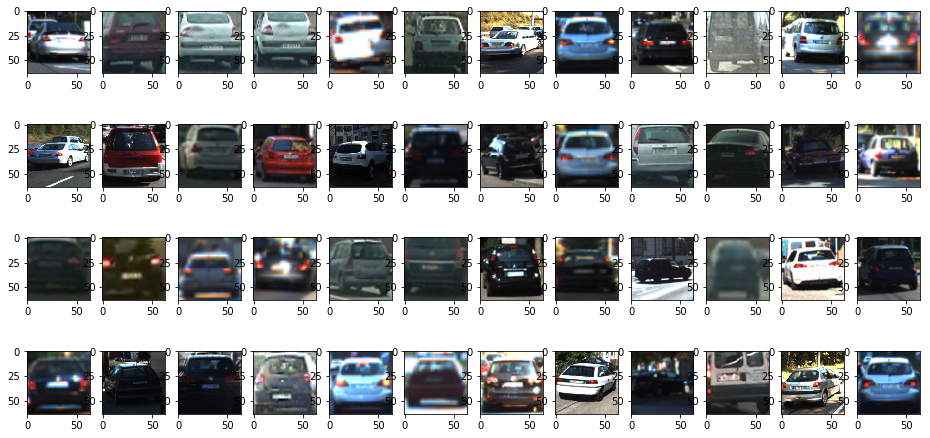

In [401]:
# plot car images then plot non car images.
rand_nums = random.sample(range(0,len(car_files)),48)

plot_sample_raw_images(rand_nums,car_files)

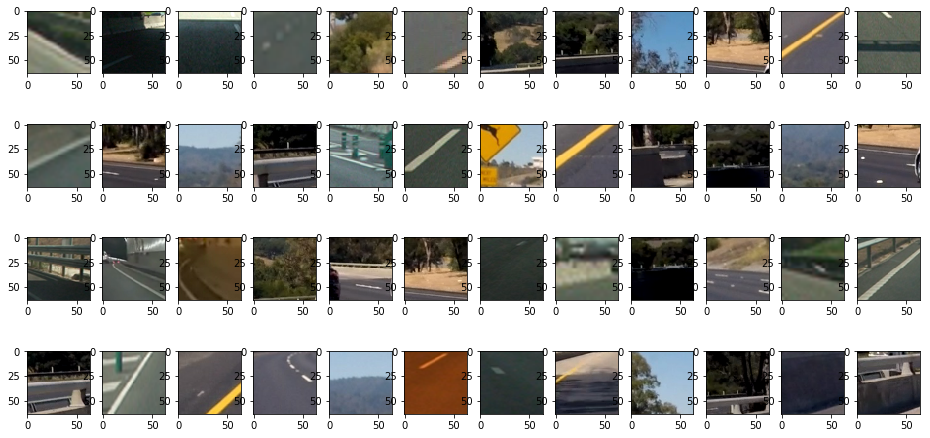

In [402]:
# plot car images then plot non car images.
rand_nums = random.sample(range(0,len(noncar_files)),48)

plot_sample_raw_images(rand_nums,noncar_files)

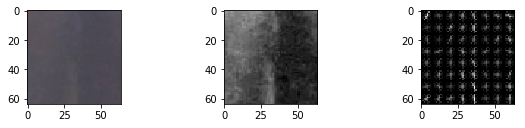

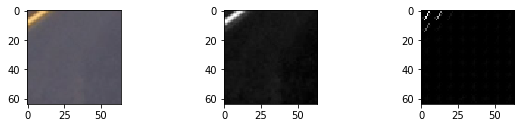

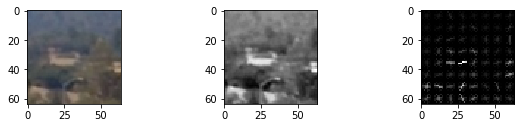

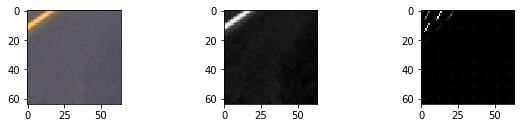

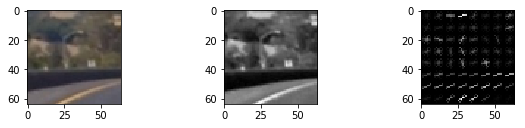

In [328]:
rand_nums = random.sample(range(0,len(car_features)),5)

cur_files = noncar_files
cur_features = non_car_features

plot_sample_images(rand_nums,cur_files,cur_features)

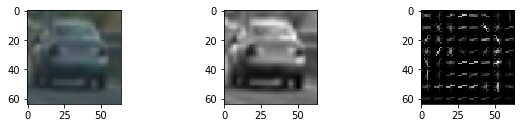

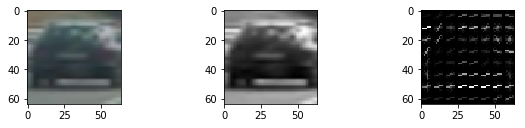

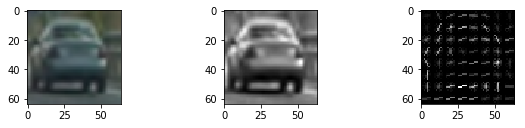

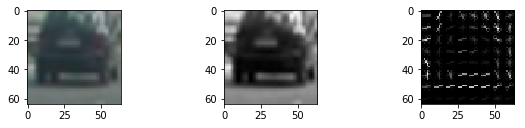

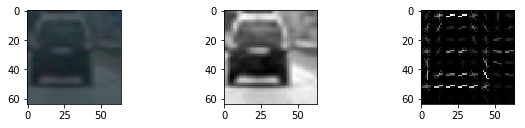

In [327]:
rand_nums = random.sample(range(0,len(car_features)),5)

cur_files = car_files
cur_features = car_features

plot_sample_images(rand_nums,cur_files,cur_features)

In [144]:
# 4. normalize feature set
car_features_np = np.array(car_features)
print("num car pictures and features: ",car_features_np.shape)

non_car_features_np = np.array(non_car_features)
print("num car pictures and features: ",non_car_features_np.shape)

##stack car and noncar features
combined_features_np = np.vstack([car_features_np,non_car_features_np])
print("num combined pictures and features: ",combined_features_np.shape)
print(np.min(combined_features_np),np.max(combined_features_np),np.mean(combined_features_np))

## scaling similar to model
scaler = StandardScaler().fit(combined_features_np)
combined_features_np_scaled = scaler.transform(combined_features_np)
print("num combined pictures and features after scaling: ",combined_features_np_scaled.shape)
## seems to center at zero
print(np.min(combined_features_np_scaled),np.max(combined_features_np_scaled),np.mean(combined_features_np_scaled))

# 5. create labels - nicely done here.
## first x = car , botton x = noncar
labels_car = np.ones(car_features_np.shape[0])
labels_non_car = np.zeros(non_car_features_np.shape[0])
labels = np.hstack([labels_car,labels_non_car])
print(labels.shape)


# 6. split dataset into train and test set
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    combined_features_np, labels, test_size=0.2, random_state=rand_state)
print("train set x, y:",len(X_train),len(y_train))
print("test set x, y:",len(X_test),len(y_test))

# 7. train svm model
# initial SVM with params
# specify kernel ( linear, non linear), narrow or wide margin, number of samples of points
clf = LinearSVC()
clf.fit(X_train,y_train)
# this prints accuray. so 13% which seems low
print("mean accuracy",clf.score(X_test,y_test))

print("recall score" ,recall_score(y_test,clf.predict(X_test)))
print("precision score" ,precision_score(y_test,clf.predict(X_test)))
# this is a weighted average of the recall and precision so should be in between
print("f1score score" ,f1_score(y_test,clf.predict(X_test)))

# 8. output results

('num car pictures and features: ', (8792, 5292))
('num car pictures and features: ', (8968, 5292))
('num combined pictures and features: ', (17760, 5292))
(0.0, 0.99750222569508318, 0.027739409636475042)
('num combined pictures and features after scaling: ', (17760, 5292))
(-1.3109616417808843, 50.930808347787909, 7.1308806944705783e-17)
(17760,)
('train set x, y:', 14208, 14208)
('test set x, y:', 3552, 3552)
('mean accuracy', 0.9817004504504504)
('recall score', 0.97701793721973096)
('precision score', 0.98641765704584039)
('f1score score', 0.98169529709940861)


In [145]:
model_dict = {}
model_dict['svc'] = clf
model_dict['scaler'] = scaler
model_dict['orient'] = extract_params['orient']
model_dict['pix_per_cell'] = extract_params['pix_per_cell']
model_dict['cell_per_block'] = extract_params['cell_per_block']
model_dict['spatial_feat'] = extract_params['spatial_feat']
model_dict['hist_feat'] = extract_params['hist_feat']
model_dict['hog_feat'] = extract_params['hog_feat']
model_dict['color_space'] = extract_params['color_space']
model_dict['model_recall_score'] = recall_score(y_test,clf.predict(X_test))
model_dict['model_precision_score'] = precision_score(y_test,clf.predict(X_test))
model_dict['model_training_num_samples_features'] = combined_features_np_scaled.shape

s = pickle.dump(model_dict,open("model_hog_3_channel_YCrCb_incl.p","wb"))
#s = pickle.dump(model_dict,open("model_hog_3_channel_spatial_hist_YCrCb_incl.p","wb"))
#s = pickle.dump(model_dict,open("model_hog_3_channel_spatial_hist_incl.p","wb"))
#s = pickle.dump(model_dict,open("model_hog_3_channel.p","wb"))

In [146]:
#dist_pickle = pickle.load(open("model_hog_3_channel.p","rb"))
#dist_pickle = pickle.load(open("model_hog_3_channel_spatial_hist_incl.p","rb"))
#dist_pickle = pickle.load(open("model_hog_3_channel_spatial_hist_YCrCb_incl.p","rb"))
dist_pickle = pickle.load(open("model_hog_3_channel_YCrCb_incl.p","rb"))
print(type(dist_pickle))

svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_feat = model_dict['spatial_feat']
hist_feat = model_dict['hist_feat']
hog_feat = model_dict['hog_feat']
color_space = model_dict['color_space']
model_recall = model_dict['model_recall_score']
model_precision_score = model_dict['model_precision_score']
model_train_num_samples_features = model_dict['model_training_num_samples_features']

for k,v in dist_pickle.iteritems():
    print(k,v)

<type 'dict'>
('model_recall_score', 0.97701793721973096)
('color_space', 'YCrCb')
('pix_per_cell', 8)
('model_precision_score', 0.98641765704584039)
('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))
('cell_per_block', 2)
('hog_feat', True)
('svc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))
('hist_feat', False)
('model_training_num_samples_features', (17760, 5292))
('orient', 9)
('spatial_feat', False)


2. Add Sliding Window

In [64]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

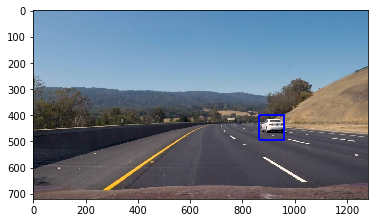

In [200]:
## version with bounding boxes only
# expected:
# https://docs.google.com/spreadsheets/d/14Wjri_t-QfGFRjHzzpbpbUJPFKOX3dT93hAW0TDz0J0/edit#gid=0

# Method borrow this from the tutorial

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
              spatial_feat,hist_feat,hog_feat,color_space):
    
    bboxes = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if color_space != False:
        #print("converting colors")
        if color_space == 'YCrCb':
            color_space = 'RGB2YCrCb'
        ctrans_tosearch = convert_color(img_tosearch, color_space)
    else:
        ctrans_tosearch = img
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    #nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    #nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nxblocks = (ch1.shape[1] // pix_per_cell)+1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    #nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nblocks_per_window = (window // pix_per_cell)-1 
    
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            comb_features = []
            
            if hog_feat:
                # Extract HOG for this patch            
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                comb_features.append(hog_features)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_size=(32, 32)
            hist_bins=32
            if hist_feat:
                hist_features = color_hist(subimg, nbins=hist_bins)
                comb_features.append(hist_features)
            if spatial_feat:
                spatial_features = bin_spatial(subimg, size=spatial_size)
                comb_features.append(spatial_features)


            # Scale features and make a prediction
            #test_features = X_scaler.transform((hog_features).reshape(1, -1) )
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            test_features = X_scaler.transform(np.hstack((comb_features)).reshape(1, -1))  
            #print("test features",test_features.shape)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                
    return draw_img,bboxes

# 1. Generate list of car vs non car - Done
dir_name = '/Users/davidwoo/Documents/Projects/kitt-playlabs/udacity/CarND-Vehicle-Detection-master/test_images/'
file_name = 'test3.jpg'
img = mpimg.imread(dir_name + file_name)

ystart = 400
ystop = 656
scale = 1.5

svc = clf
# this stores the mean and variation for scaling. this makes sense now
X_scaler = scaler
    
window_img,bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                       spatial_feat,hist_feat,hog_feat,color_space)
plt.imshow(window_img)

In [154]:
heat_map = np.zeros(img.shape)
print("heatmap shape and image shape", heat_map.shape,img.shape,np.min(heat_map),np.max(heat_map))
    

('heatmap shape and image shape', (720, 1280, 3), (720, 1280, 3), 0.0, 0.0)


(0, 'cars found')


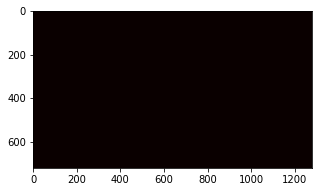

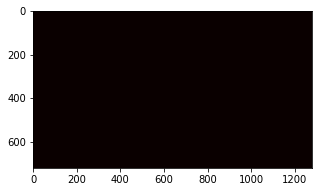

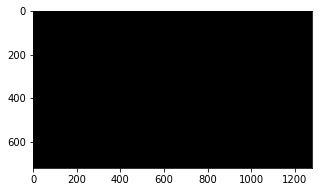

In [214]:
# Implement heatmap

def add_heat(bboxes,img):
    
    # define a np array of zeros
    img_map = np.zeros_like(img[:,:,0])
    #print("heatmap shape",heat_map.shape)
    
    # Iterate through list of bboxes
    for box in bboxes:
    
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        box_x_min_max = (box[0][0],box[1][0])
        box_y_min_max = (box[0][1],box[1][1])
        #print(box_x_min_max,box_y_min_max)
        img_map[box_y_min_max[0]:box_y_min_max[1],box_x_min_max[0]:box_x_min_max[1]] += 1

    return img_map

def apply_heat_threshold(img_map,threshold):
    
    img_map[img_map <= threshold] = 0
    
    return img_map

def get_heatmap(bboxes,img,threshold):
    
    img_map = apply_heat_threshold(add_heat(bboxes,img),threshold)
    img_labels = label(img_map)

    return img_map,img_labels
    

plt.figure(figsize=(5,5))
plt.imshow(add_heat(bboxes,img), cmap='hot')

heat_map,labels = get_heatmap(bboxes,img,1)

plt.figure(figsize=(5,5))
plt.imshow(heat_map, cmap='hot')

plt.figure(figsize=(5,5))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

# next we should draw the the bounding box if over a certain threshold

In [185]:
# see first car
labels[0].shape
labels[1]

print(np.min(labels[0]))
print(np.max(labels[0]))

# it's the size of the image
# like connected components first non-zero pixel

0
2


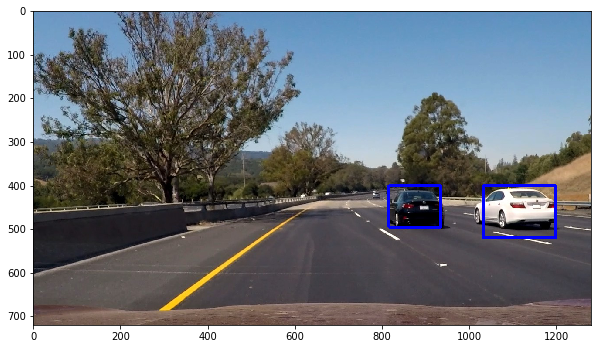

In [191]:
def draw_labeled_bboxes(img, labels):
    
    num_objs = labels[1]
    img_pixels = labels[0]
    # Loop through all detected objects
    for obj_label in range(1,num_objs+1):
        
        # Find img pixels, labelled with obj label
    
        non_zero_pix = (img_pixels == obj_label).nonzero()
        
        # Return indices of non zeros
        # np array vs chart. np array rows are y, and cols are x
        # chart, y is vertical and x is horizontal
        pixel_x_min_max = (np.min(non_zero_pix[1]),np.max(non_zero_pix[1]))
        pixel_y_min_max = (np.min(non_zero_pix[0]),np.max(non_zero_pix[0]))
        
        # Define a bounding box based on min/max x and y
        top_left = (pixel_x_min_max[0],pixel_y_min_max[0])
        bottom_right = (pixel_x_min_max[1],pixel_y_min_max[1])
        box = (top_left,bottom_right)
        #print("box coordinates",box)
        cv2.rectangle(img,box[0],box[1],(0,0,255),6) 
        
        # Draw the box on the image
        
    # Return the image and final rectangles
    return img

# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

('test img', 'test_images/test1.jpg')
('test img', 'test_images/test2.jpg')
('test img', 'test_images/test3.jpg')
('test img', 'test_images/test4.jpg')
('test img', 'test_images/test5.jpg')
('test img', 'test_images/test6.jpg')


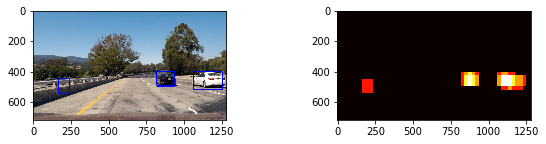

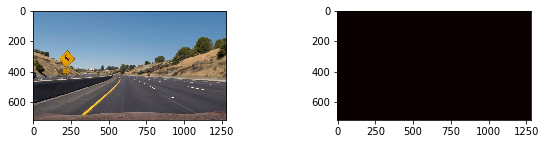

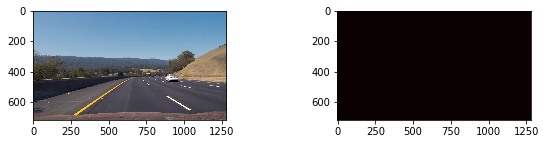

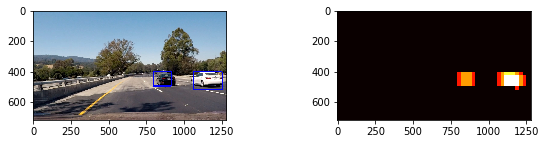

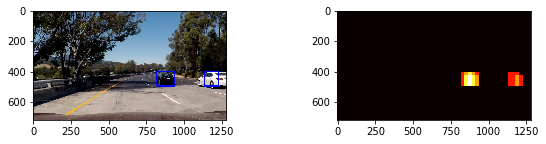

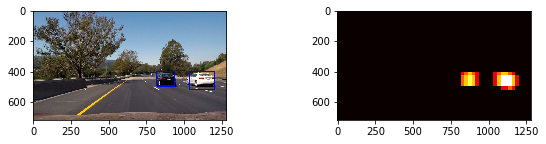

In [223]:
# 1. Generate list of car vs non car - Done

test_images = glob.glob('test_images/*.jpg')

#test_images = test_images[1:2]

for test_img in test_images:
    img = mpimg.imread(test_img)

    ystart = 400
    ystop = 656
    scale = 1.5

    svc = clf
    X_scaler = scaler
    bboxes = []
    labels = []

    window_img,bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                           spatial_feat,hist_feat,hog_feat,color_space)
    #plt.figure(figsize=(5,5))
    #plt.imshow(window_img)

    heat_map,labels = get_heatmap(bboxes,img,1)
    #print("num cars", labels[1])
    
    #plt.figure(figsize=(5,5))
    #plt.imshow(heat_map, cmap='hot')

    draw_img = draw_labeled_bboxes(img, labels)

    plt.figure(figsize=(10,2))
    print("test img",test_img)
    plt.subplot(1,2,1)
    plt.imshow(draw_img)
    plt.subplot(1,2,2)
    plt.imshow(heat_map, cmap='hot')


Below section runs the algorithm on a video

In [239]:
def process_frame(img):

    rectangles = []

    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    
    img_scales_settings = [[400,464,1],
                  [416,480,1],
                  [400,496,1.5],
                  [432,528,1.5],
                  [400,528,2],
                  [432,560,2],
                  [400,596,3.5],
                  [464,660,3.5]
                 ]
                  

    for setting in img_scales_settings:
        # starts with size of image, no scaling 
        #print("settings",setting)
        ystart = setting[0]
        ystop = setting[1]
        scale = setting[2]
        window_img,bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                               spatial_feat,hist_feat,hog_feat,color_space)
        #print("bboxes",bboxes)
        rectangles.append(bboxes)

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heat_map,labels = get_heatmap(rectangles,img,1)
    draw_img = draw_labeled_bboxes(img, labels)

    return draw_img

print('...')

...


In [240]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:14<00:00,  2.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 13.5 s, sys: 1.13 s, total: 14.6 s
Wall time: 15 s


In [241]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))